# Visualizations_COVID

## Content
- [Paths](#Paths)
- [Load data](#Load-data)
- [Atencion](#Atencion)
- [Load data](#Load-data)

## Goal of visualization
- Main plots from COVID-19 data


In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import csv
import requests
import matplotlib
import re
from sodapy import Socrata
import configparser
import boto3
plt.style.use('fivethirtyeight')
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 500)
%load_ext autoreload
%autoreload 2

In [3]:
os.chdir(os.path.join(os.getcwd(), ".."))

In [4]:
from src.config import metadata
from src.utils.s3_utils import (get_censo_paths, download_files_from_s3, read_multiple_csv,
                                mk_partitioned_dir, identified_partitioned_dir)
from src.utils.general_utils import create_dir

## Paths

In [16]:
config = configparser.ConfigParser()
config.read('aws.cfg')
aws = config["AWS"]
bucket = "censo-covid"
s3 = boto3.resource('s3',
                    region_name="us-west-2",
                    aws_access_key_id=aws['AWS_ACCESS_KEY_ID'],
                    aws_secret_access_key=aws['AWS_SECRET_ACCESS_KEY'])
s3_client = boto3.client('s3',
                         aws_access_key_id=aws['AWS_ACCESS_KEY_ID'],
                         aws_secret_access_key=aws['AWS_SECRET_ACCESS_KEY']
                        )

# Local paths
data_path = os.path.join(os.getcwd(), "data")
censo_data_path = os.path.join(data_path, "censo")
covid_path = os.path.join(os.getcwd(), "data", "covid.csv")
divipola_path = os.path.join(os.getcwd(), "data", "divipola.csv")
#complete_fallecidos_path = os.path.join(data_path, "complete_fallecidos") # Heavy downloads
#complete_personas_path = os.path.join(data_path, "complete_fallecidos") # Really heavy download
aggregates_path = os.path.join(data_path,'aggregates')
aggregates_personas_path = os.path.join(aggregates_path, 'personas')
aggregates_fallecidos_path = os.path.join(aggregates_path, 'fallecidos')
aggregates_covid_path = os.path.join(aggregates_path, 'covid')
joins_path = os.path.join(data_path,'joins')
joins_personas_path = os.path.join(joins_path, 'personas')
joins_fallecidos_path = os.path.join(data_path,'fallecidos')

# S3 paths
censo_covid_bucket_s3 = f"s3a://{bucket}"

raw_data_path_s3 = os.path.join(censo_covid_bucket_s3, "raw-data")
censo_data_path_s3 = os.path.join(raw_data_path_s3, "censo")
covid_tests_path_s3 = os.path.join(raw_data_path_s3, "covid-tests.csv")
covid_path_s3 = os.path.join(raw_data_path_s3, "covid.csv")
divipola_path_s3 = os.path.join(raw_data_path_s3, "divipola.csv")

final_data_path_s3 = os.path.join(censo_covid_bucket_s3, "final-data")
#complete_personas_path = os.path.join(final_data_path, "complete_personas")# Heavy downloads
#complete_fallecidos_path = os.path.join(final_data_path, "complete_fallecidos")# Really heavy download

aggregates_personas_path_s3 = os.path.join(final_data_path, "aggregates_personas")
aggregates_fallecidos_path_s3 = os.path.join(final_data_path, "aggregates_fallecidos")
aggregates_covid_path_s3 = os.path.join(final_data_path, "aggregates_covid")

join_personas_covid_path_s3 = os.path.join(final_data_path, "join_personas_covid")
join_fallecidos_covid_path_s3 = os.path.join(final_data_path, "join_fallecidos_covid")

s3Bucket = s3.Bucket(bucket)

# Load data

In [20]:
create_dir(covid_path)

/Users/camilovelasquez/Desktop/Documents/Camilo/Udacity/censo_covid_colombia/data/covid.csv dir exists


In [30]:
download_files_from_s3(covid_path, s3Bucket, prefix=censo_data_path_s3.replace(censo_covid_bucket_s3 + "/", ""))

Is a file


In [47]:
df = pd.read_csv(covid_path)
df["rango_edad"] = pd.cut(df["edad"], np.append(np.arange(-1, 100, 5),df["edad"].max()))
df.head()

/Users/camilovelasquez/anaconda3/envs/censo/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3072: DtypeWarning: Columns (9,12,14,17,18,19) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,fecha_de_notificaci_n,c_digo_divipola,ciudad_de_ubicaci_n,departamento,atenci_n,edad,sexo,tipo,estado,pa_s_de_procedencia,fis,fecha_diagnostico,fecha_recuperado,fecha_reporte_web,tipo_recuperaci_n,codigo_departamento,codigo_pais,pertenencia_etnica,nombre_grupo_etnico,fecha_de_muerte,Asintomatico,divipola_dpto,divipola_mpio,edad_q,muerto,edad_muerto,rango_edad
0,2020-03-02,11001,Bogotá D.C.,Bogotá D.C.,Recuperado,19,F,Importado,Leve,ITALIA,2020-02-27,2020-03-06,2020-03-13,2020-03-06,PCR,11,380.0,Otro,NaN,NaN,0,11,1,1,False,0,"(14, 19]"
1,2020-03-06,76111,Guadalajara de Buga,Valle del Cauca,Recuperado,34,M,Importado,Leve,ESPAÑA,2020-03-04,2020-03-09,2020-03-19,2020-03-09,PCR,76,724.0,Otro,NaN,NaN,0,76,111,2,False,0,"(29, 34]"
2,2020-03-07,5001,Medellín,Antioquia,Recuperado,50,F,Importado,Leve,ESPAÑA,2020-02-29,2020-03-09,2020-03-15,2020-03-09,PCR,5,724.0,Otro,NaN,NaN,0,5,1,3,False,0,"(49, 54]"
3,2020-03-09,5001,Medellín,Antioquia,Recuperado,55,M,Relacionado,Leve,NaN,2020-03-06,2020-03-11,2020-03-26,2020-03-11,PCR,5,NaN,Otro,NaN,NaN,0,5,1,4,False,0,"(54, 59]"
4,2020-03-09,5001,Medellín,Antioquia,Recuperado,25,M,Relacionado,Leve,NaN,2020-03-08,2020-03-11,2020-03-23,2020-03-11,PCR,5,NaN,Otro,NaN,NaN,0,5,1,5,False,0,"(24, 29]"


### Atencion

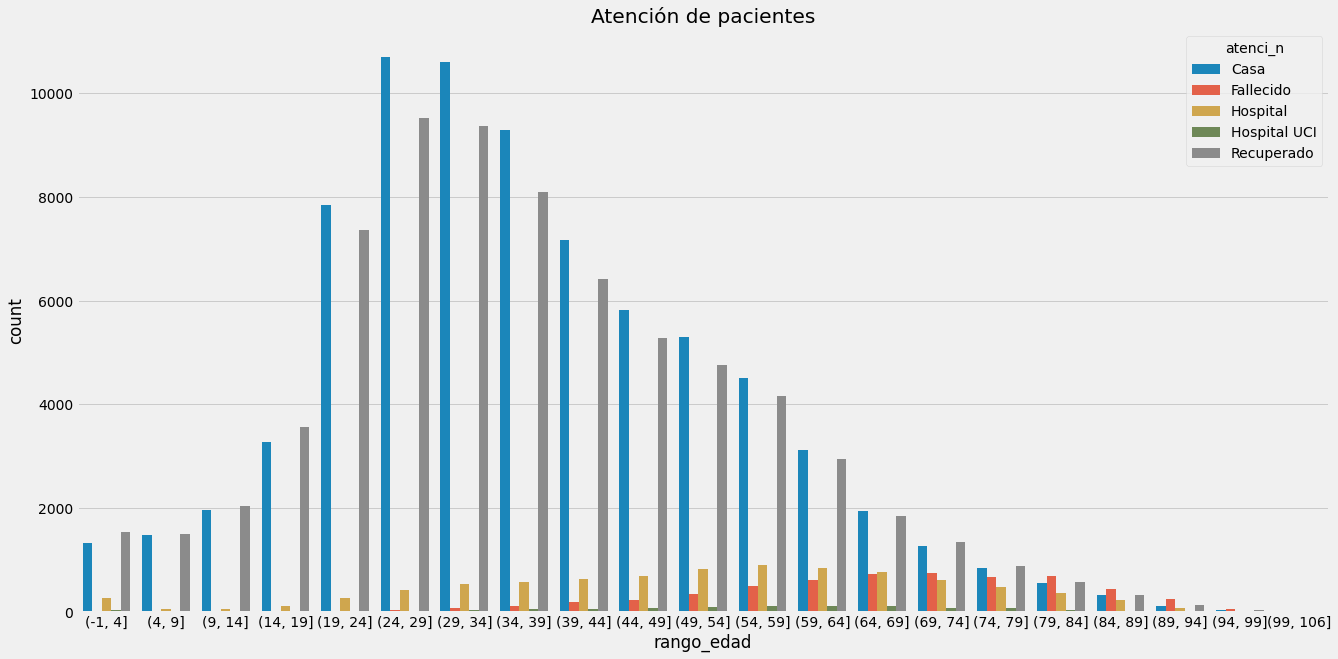

In [36]:
aux = df.groupby(["rango_edad", "atenci_n"])["atenci_n"].agg(["count"])
ex = aux.rename(columns={"atenci_n": "count"}).reset_index()
ex = ex.rename(columns={0: "count"})
fig, ax = plt.subplots(figsize=(20,10))
ax = sns.barplot(x="rango_edad", y="count", 
                 hue="atenci_n", 
                 data=ex[ex["atenci_n"].isin(["Recuperado", "Fallecido", "Hospital UCI", "Hospital", "Casa"])], ax=ax)
ax.set_title("Atención de pacientes")
plt.show()

In [42]:
total_por_rango_de_edad = df.groupby(["rango_edad"])["atenci_n"].agg(["count"])

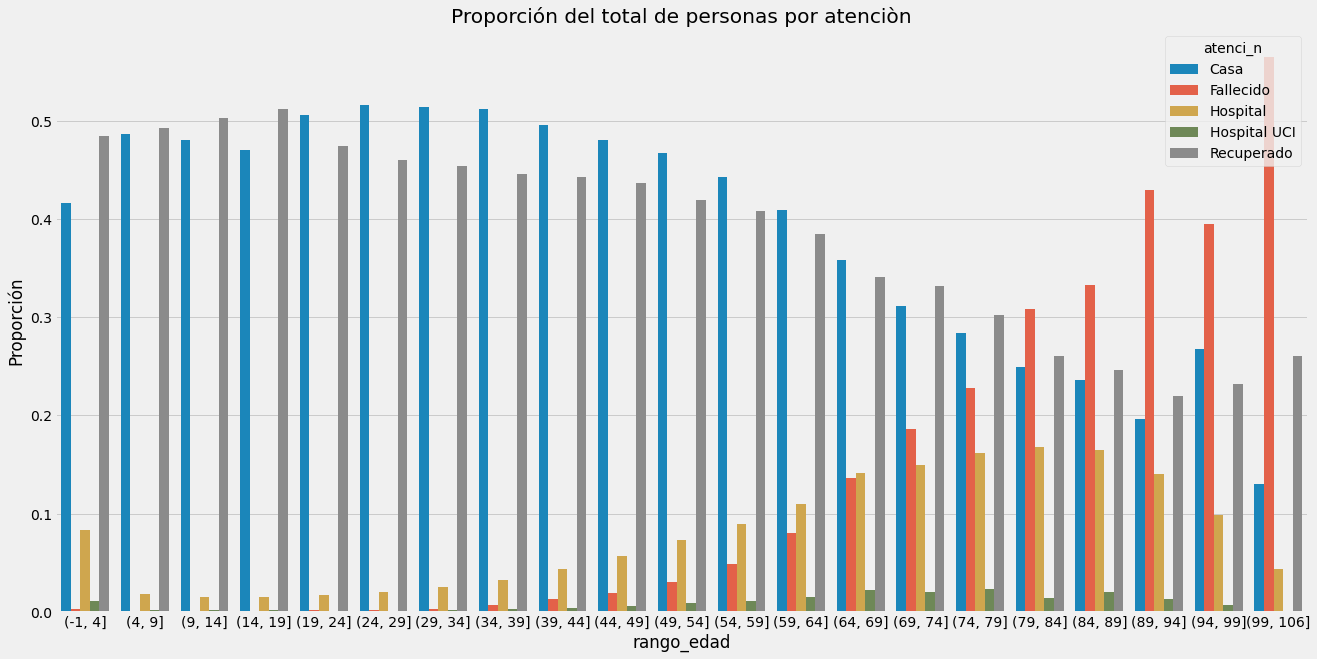

In [57]:
aux = df.groupby(["rango_edad", "atenci_n"])["atenci_n"].agg(["count"])
aux = aux.loc[:,:]/total_por_rango_de_edad
ex = aux.rename(columns={"atenci_n": "count"}).reset_index()
ex = ex.rename(columns={0: "count"})
fig, ax = plt.subplots(figsize=(20,10))
ax = sns.barplot(x="rango_edad", y="count", 
                 hue="atenci_n", 
                 data=ex[ex["atenci_n"].isin(["Recuperado", "Fallecido", "Hospital UCI", "Hospital", "Casa"])], ax=ax)
ax.set_title("Proporción del total de personas por atenciòn")
ax.set_ylabel("Proporción")
plt.show()

### Recuperado vs Fallecido

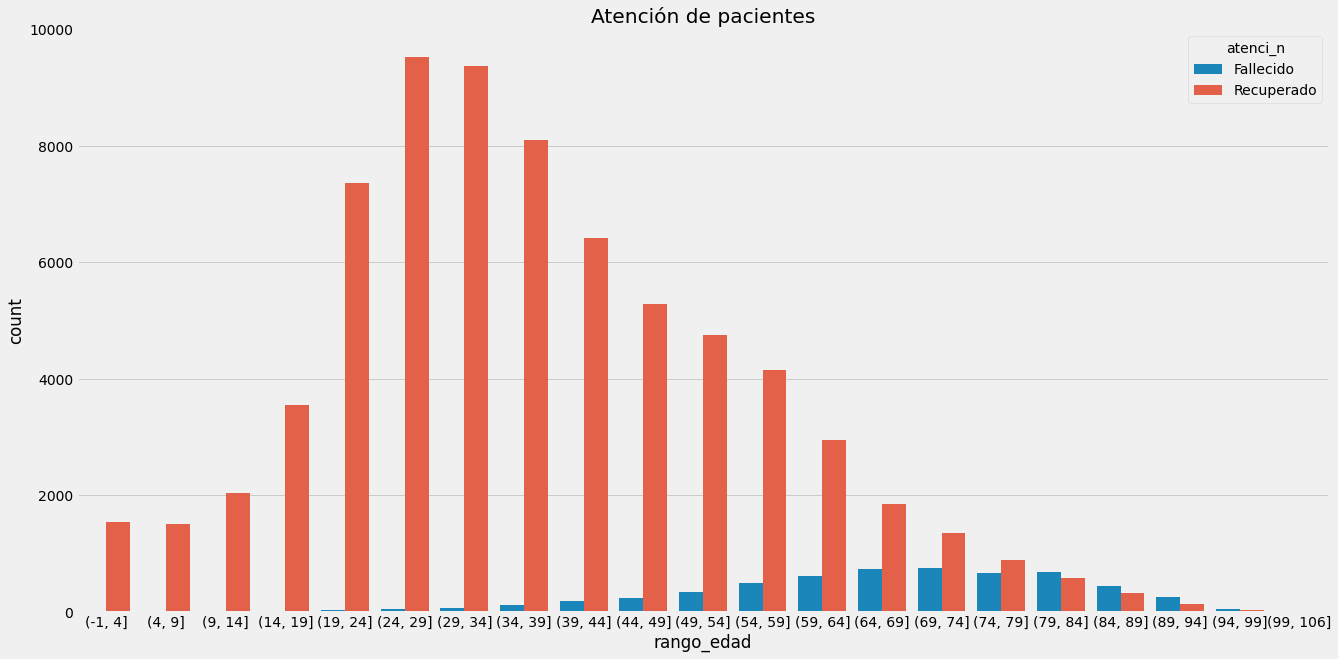

In [60]:
aux = df[df["atenci_n"].isin(["Recuperado", "Fallecido"])].groupby(["rango_edad", "atenci_n"])["atenci_n"].agg(["count"])
ex = aux.rename(columns={"atenci_n": "count"}).reset_index()
ex = ex.rename(columns={0: "count"})
fig, ax = plt.subplots(figsize=(20,10))
ax = sns.barplot(x="rango_edad", y="count", 
                 hue="atenci_n", 
                 data=ex[ex["atenci_n"].isin(["Recuperado", "Fallecido", "Hospital UCI", "Hospital", "Casa"])], ax=ax)
ax.set_title("Atención de pacientes")
plt.show()

In [61]:
total = df[df["atenci_n"].isin(["Recuperado", "Fallecido"])].groupby(["rango_edad"])["atenci_n"].agg(["count"])

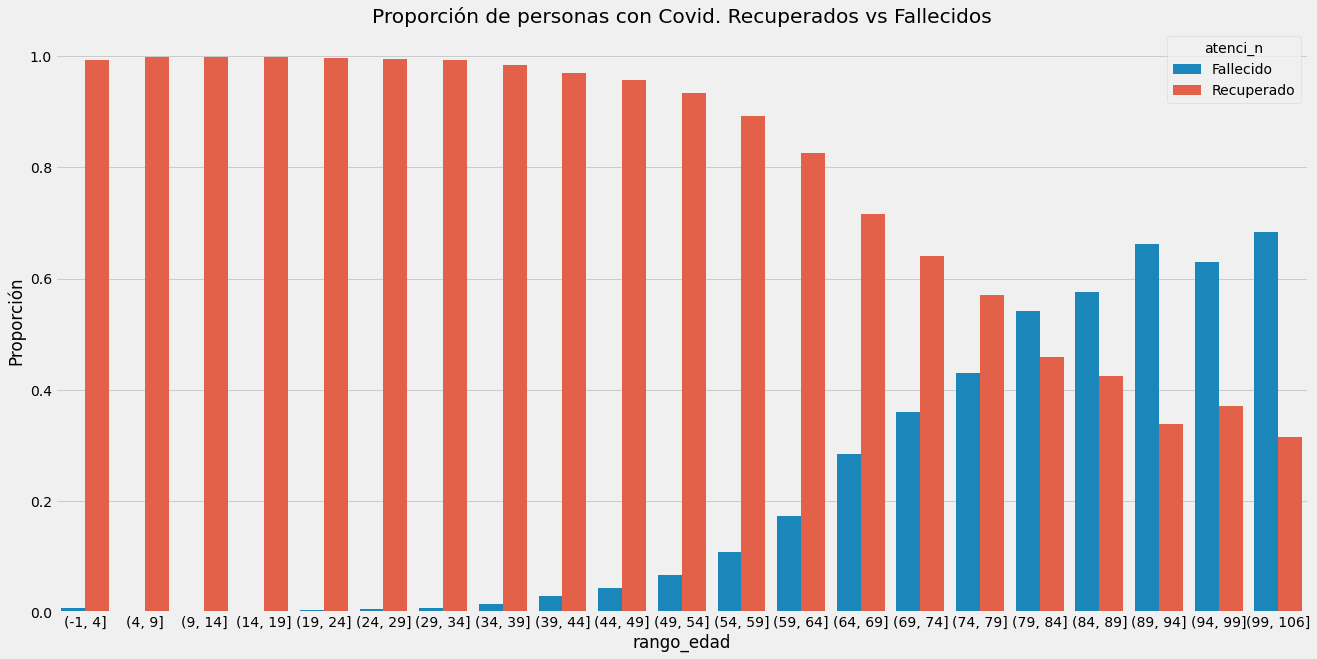

In [64]:
aux = df[df["atenci_n"].isin(["Recuperado", "Fallecido"])].groupby(["rango_edad", "atenci_n"])["atenci_n"].agg(["count"])
aux = aux.loc[:,:]/total
ex = aux.rename(columns={"atenci_n": "count"}).reset_index()
ex = ex.rename(columns={0: "count"})
fig, ax = plt.subplots(figsize=(20,10))
ax = sns.barplot(x="rango_edad", y="count", 
                 hue="atenci_n", 
                 data=ex[ex["atenci_n"].isin(["Recuperado", "Fallecido", "Hospital UCI", "Hospital", "Casa"])], ax=ax)
ax.set_title("Proporción de personas con Covid. Recuperados vs Fallecidos")
ax.set_ylabel("Proporción")
plt.show()

### Estado

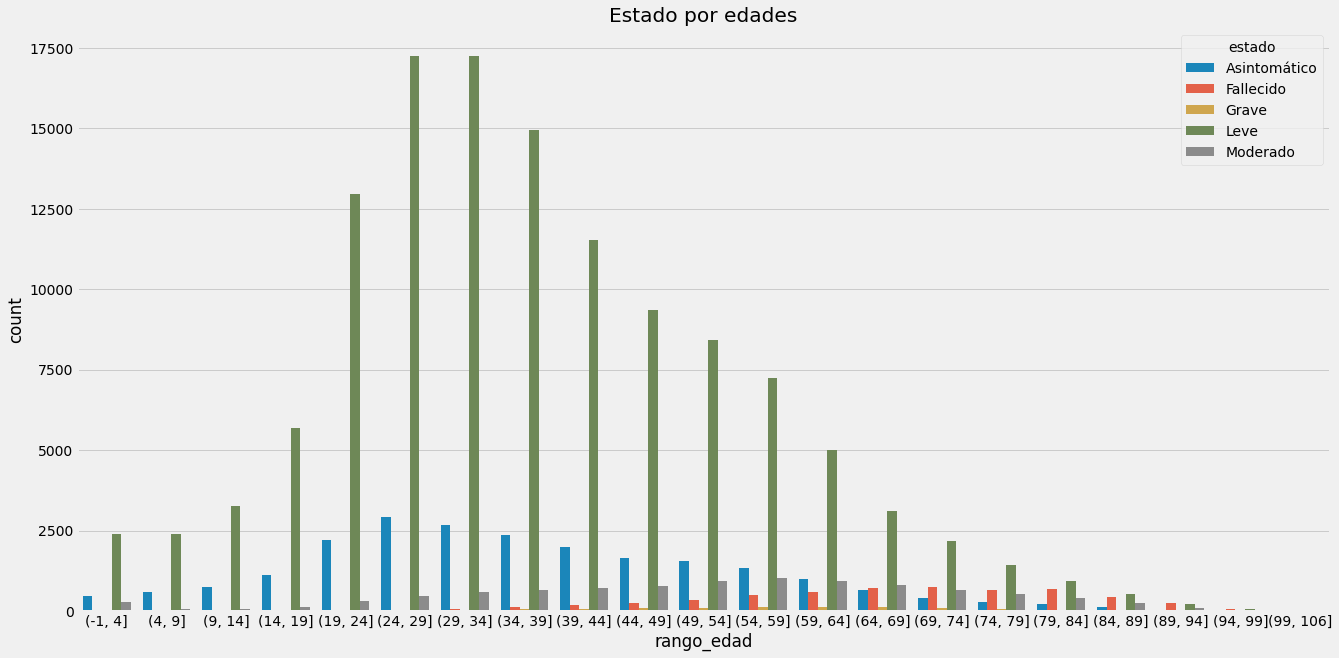

In [54]:
aux = df.groupby(["rango_edad", "estado"])["estado"].agg(["count"])
ex = aux.rename(columns={"estado": "count"}).reset_index()
fig, ax = plt.subplots(figsize=(20,10))
ax = sns.barplot(x="rango_edad", y="count", 
                 hue="estado", 
                 data=ex, ax=ax)
ax.set_title("Estado por edades")
plt.show()

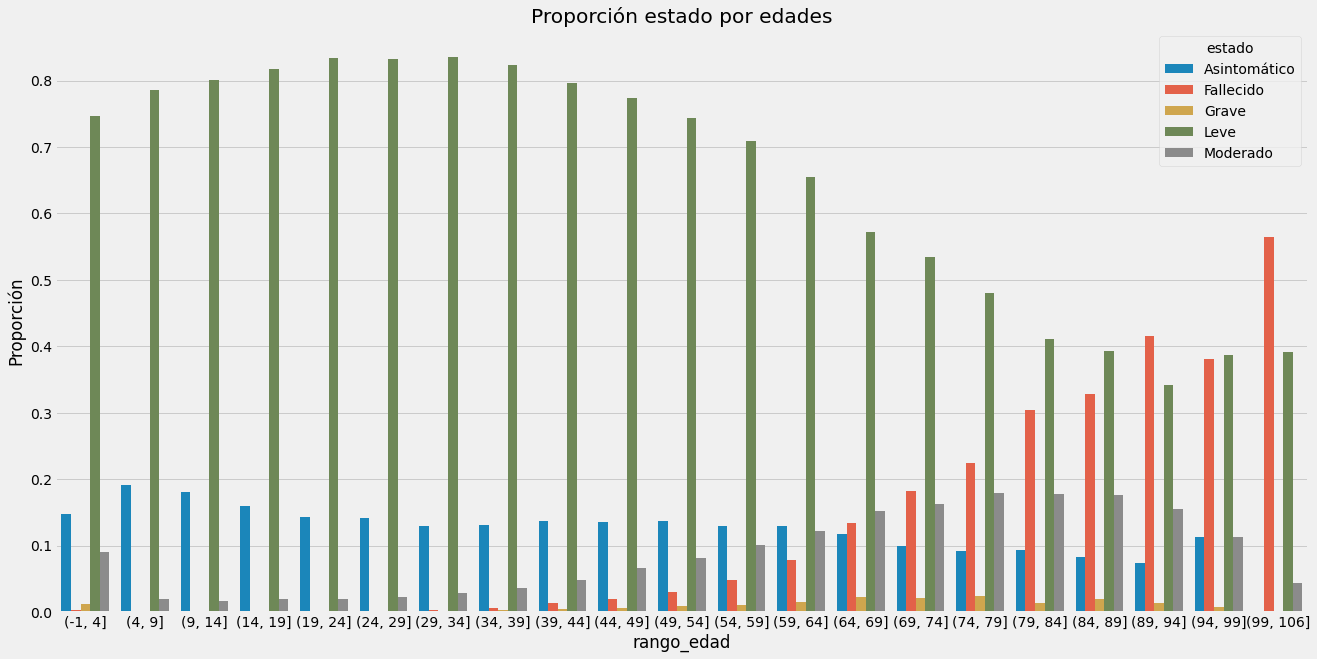

In [58]:
aux = df.groupby(["rango_edad", "estado"])["estado"].agg(["count"])
aux = aux.loc[:,:]/total_por_rango_de_edad
ex = aux.rename(columns={"estado": "count"}).reset_index()
fig, ax = plt.subplots(figsize=(20,10))
ax = sns.barplot(x="rango_edad", y="count", 
                 hue="estado", 
                 data=ex, ax=ax)
ax.set_title("Proporción estado por edades")
ax.set_ylabel("Proporción")
plt.show()